In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from scipy.interpolate import interp1d
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
    weighted_quantile,
)

In [2]:
collated_eos_path = [
    '../data/eos-draws-default.csv',
    '../data/collated_np_all_post.csv',
][0]

In [3]:
collated_eos = pd.read_csv(collated_eos_path)
astro_weights = np.exp(collated_eos.logweight_total.values)

In [4]:
collated_eos

,eos,logweight_total,Mmax,pressurec2(baryon_density=2.8e+14),pressurec2(baryon_density=5.6e+14),pressurec2(baryon_density=1.68e+15),energy_densityc2(baryon_density=2.8e+14),energy_densityc2(baryon_density=5.6e+14),energy_densityc2(baryon_density=1.68e+15),R(M=1.4),...,weight_05nsat_marg,weight_06nsat_marg,weight_07nsat_marg,weight_08nsat_marg,weight_09nsat_marg,weight_10nsat_marg,weight_15nsat_marg,weight_20nsat_marg,weight_ntov_marg,abs_nterm
0,1295491.0,-108.122200,2.603362,1.347181e+13,1.157996e+14,5.100930e+14,2.781826e+14,6.044199e+14,2.381410e+15,15.331616,...,3.590056e-48,4.275697e-48,4.470014e-48,3.986425e-48,3.053029e-48,2.520510e-48,1.499629e-48,2.592780e-49,1.982408e-48,66622.050047
1,801190.0,-136.954400,2.854403,2.890948e+13,1.373165e+14,1.820736e+15,2.893194e+14,6.546181e+14,2.982779e+15,17.036945,...,7.561927e-157,1.115116e-261,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.378420e-61,6.634561
2,1045196.0,-7.759387,1.884972,8.489347e+12,5.316641e+13,5.931912e+14,2.777501e+14,5.774545e+14,2.098917e+15,13.443280,...,6.743437e-04,4.607579e-04,3.947435e-04,3.205078e-04,1.824641e-04,9.550086e-05,3.962505e-05,4.131443e-05,3.912141e-04,115.119503
3,2096819.0,-114.869400,3.450041,1.877969e+13,2.769144e+14,1.316527e+15,2.912876e+14,6.841185e+14,3.297290e+15,15.694826,...,2.809477e-264,6.027900e-260,6.740242e-250,3.223529e-250,2.563612e-242,2.953364e-239,0.000000e+00,0.000000e+00,7.335953e-132,3.406358
4,1459215.0,6.756822,2.334307,7.630696e+12,6.130517e+13,8.417335e+14,2.773685e+14,5.750875e+14,2.306016e+15,13.485055,...,2.503985e+02,1.224831e+02,7.859788e+01,5.680655e+01,3.906689e+01,2.974271e+01,1.449280e+01,4.991400e+00,2.037753e+02,38.880983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80157,1715903.0,5.070087,2.015742,3.721870e+12,4.201063e+13,6.533895e+14,2.760359e+14,5.654943e+14,2.102774e+15,12.236965,...,2.080784e+02,1.442289e+02,9.862063e+01,8.628054e+01,8.672481e+01,8.917511e+01,7.141242e+01,4.351624e+01,1.075708e+02,22294.282631
80158,1852746.0,-5.325922,2.065641,1.408507e+13,4.716668e+13,4.344421e+14,2.783922e+14,5.812388e+14,2.152024e+15,14.406849,...,6.025228e-03,6.132919e-03,4.243522e-03,2.083225e-03,8.773898e-04,3.824605e-04,5.256699e-04,1.513852e-03,6.280476e-03,24.464896
80159,525490.0,4.636692,1.993610,6.913206e+12,5.200981e+13,7.396218e+14,2.832244e+14,5.841795e+14,2.177749e+15,12.704702,...,8.934113e+01,4.972706e+01,3.016917e+01,1.538005e+01,5.826571e+00,5.697191e-01,1.092476e-98,0.000000e+00,3.095170e+01,9.305680
80160,1940558.0,7.238117,2.421531,5.137387e+12,4.872923e+13,1.200798e+15,2.765713e+14,5.659790e+14,2.360391e+15,12.407550,...,5.233576e+01,3.204839e-02,1.535437e-04,8.619252e-07,4.631873e-08,4.876283e-09,1.305107e-13,1.252040e-25,1.259546e-01,17.284680


In [5]:
list(collated_eos.columns)

['eos',
 'logweight_total',
 'Mmax',
 'pressurec2(baryon_density=2.8e+14)',
 'pressurec2(baryon_density=5.6e+14)',
 'pressurec2(baryon_density=1.68e+15)',
 'energy_densityc2(baryon_density=2.8e+14)',
 'energy_densityc2(baryon_density=5.6e+14)',
 'energy_densityc2(baryon_density=1.68e+15)',
 'R(M=1.4)',
 'R(M=2.0)',
 'Lambda(M=1.4)',
 'Lambda(M=2.0)',
 'DeltaR(2.0-1.4)',
 'rhoc(M@Mmax)',
 'cs2c2max',
 'baryon_density(cs2c2@cs2c2max)',
 'pressurec2(cs2c2@cs2c2max)',
 'numbranch',
 'R(M=1.6)',
 'R(M=1.8)',
 'logweight_Miller_J0030_threespot',
 'logweight_Miller_J0740',
 'logweight_Antoniadis_J0348',
 'logweight_LVC_GW170817_PhenomPNRTlo',
 'logweight_LVC_GW190425_PhenomPNRThi',
 'Lambda(M=1.6)',
 'Lambda(M=1.8)',
 'R(M=2.2)',
 'Lambda(M=1.0)',
 'Lambda(M=1.2)',
 'Lambda(M=2.2)',
 'R(M=1.2)',
 'R(M=1.0)',
 'logweight_Fonseca_J0740',
 'weight_01nsat_Xmarg',
 'weight_01nsat_X0.5',
 'weight_01nsat_X2',
 'weight_02nsat_Xmarg',
 'weight_02nsat_X0.5',
 'weight_02nsat_X2',
 'weight_03nsat_Xmarg',

In [6]:
# Download the EOSs

eos_dir = 'lg:/home/philippe.landry/nseos/eos/gp/mrgagn'
target_dir = '../data/eos-draws-default'

download = False
if download:
    for eos in collated_eos.eos[:2000]:
        eos = int(eos)
        os.system(f'scp {eos_dir}/DRAWmod1000-{int(eos/1000):06}/eos-draw-{eos:06}.csv {target_dir}/')
        os.system(f'scp {eos_dir}/DRAWmod1000-{int(eos/1000):06}/macro-draw-{eos:06}.csv {target_dir}/')

### Pressure vs energy density

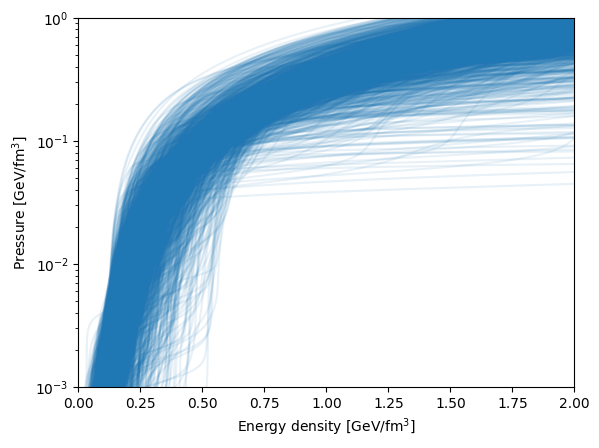

In [7]:
fig, ax = plt.subplots()
ax.set_yscale('log')

for eos in collated_eos.eos[:2000]:

    eos = int(eos)

    df = pd.read_csv(f'{target_dir}/eos-draw-{eos:06}.csv')

    pressure = df.pressurec2
    energy_density = df.energy_densityc2

    ax.plot(
        to_GeV_per_cubic_femtometre(energy_density), 
        to_GeV_per_cubic_femtometre(pressure), 
        alpha=0.1, 
        c='C0'
        )

ax.set_ylim(1e-3, 1)
ax.set_xlim(0., 2)

ax.set_xlabel('Energy density [GeV/fm$^3$]')
_ = ax.set_ylabel('Pressure [GeV/fm$^3$]')

The new QCD likelihood requires the "last" value of the EOS (the EOS at what it calls the termination density). However, the new QCD likelihood only accepts densities up to 35 times nuclear saturation. The GP EOSs typically go to much higher densities than this:

Text(0.5, 0, 'Max density [1/fm$^3$]')

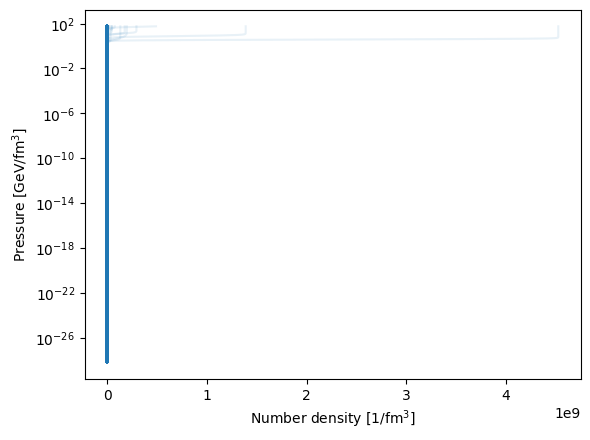

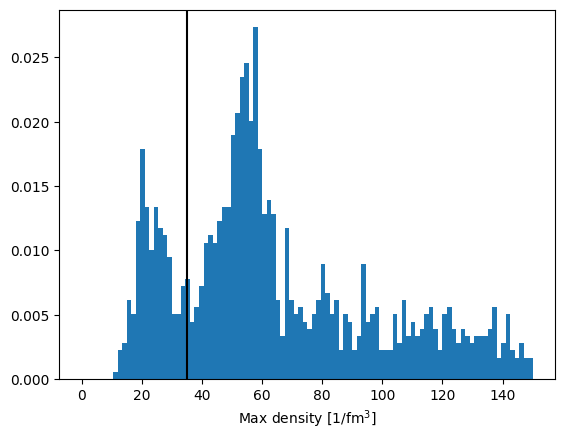

In [8]:
fig, ax = plt.subplots()
ax.set_yscale('log')

n0_list = []
for eos in collated_eos.eos[:2000]:

    eos = int(eos)

    df = pd.read_csv(f'{target_dir}/eos-draw-{eos:06}.csv')

    pressure = df.pressurec2
    energy_density = df.energy_densityc2
    number_density = df.baryon_density

    n0_list.append(max(to_nucleons_per_cubic_femtometre(number_density).values))

    ax.plot(
        to_nucleons_per_cubic_femtometre(number_density), 
        to_GeV_per_cubic_femtometre(pressure), 
        alpha=0.1, 
        c='C0'
        )
    
n0_list = np.array(n0_list)

# ax.set_ylim(1e-3, 1)
# ax.set_xlim(0., 35*0.16)

ax.set_xlabel('Number density [1/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]')

fig, ax = plt.subplots()

ax.hist(n0_list/0.16, bins=100, density=True, range=(0,150))
ax.axvline(35, c='k')

ax.set_xlabel('Max density [1/fm$^3$]')

We can alternatively use the central density, which I think is the same as nTOV, which is like the last "physical" point of the EOS?

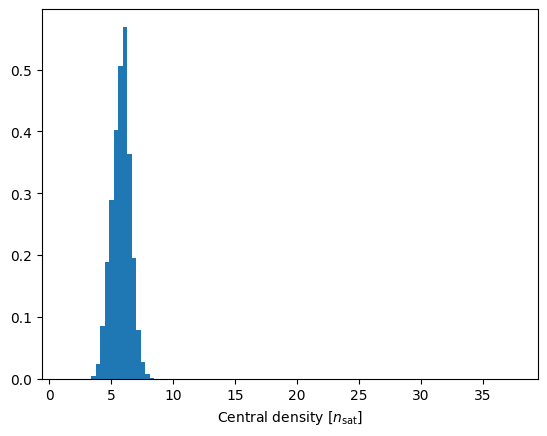

In [9]:
fig, ax = plt.subplots()
ax.hist(
    to_nucleons_per_cubic_femtometre(collated_eos['rhoc(M@Mmax)'])/0.16, 
    bins=100, 
    density=True,
    weights=np.exp(collated_eos.logweight_total.values),
    )
_ = ax.set_xlabel('Central density [$n_\mathrm{sat}$]')

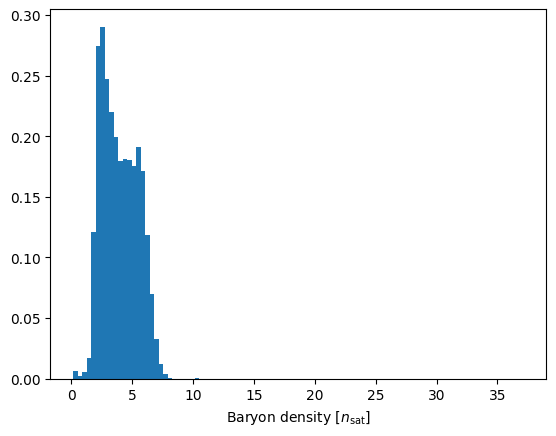

In [10]:
fig, ax = plt.subplots()
ax.hist(
    to_nucleons_per_cubic_femtometre(collated_eos['baryon_density(cs2c2@cs2c2max)'])/0.16, 
    bins=100, 
    density=True, 
    weights=np.exp(collated_eos.logweight_total.values)
    )
_ = ax.set_xlabel('Baryon density [$n_\mathrm{sat}$]')

In [11]:
# Note that some still don't work...
max(to_nucleons_per_cubic_femtometre(collated_eos['rhoc(M@Mmax)'])/0.16)

37.638379763007016

### Interpolation and quantile calculation tests

In [12]:
energy_density_grid = np.linspace(1e-10, 5, 1000)
pressure_interp = []
number_density_interp = []

for eos in collated_eos.eos[:2000]:

    eos = int(eos)

    df = pd.read_csv(f'{target_dir}/eos-draw-{eos:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values

    pressure_interp.append(interp1d(energy_density, pressure)(energy_density_grid))
    number_density_interp.append(interp1d(energy_density, number_density)(energy_density_grid))

pressure_interp = np.array(pressure_interp)
number_density_interp = np.array(number_density_interp)

In [13]:
weighted_quantiles = []

for i in range(len(energy_density_grid)):
    weighted_quantiles.append(weighted_quantile(pressure_interp[:,i], [0.05, 0.5, 0.95], weights=astro_weights[:2000]))

weighted_quantiles = np.array(weighted_quantiles).T

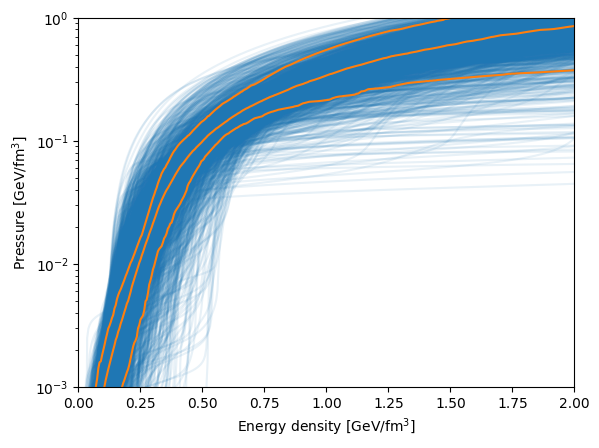

In [14]:
fig, ax = plt.subplots()
ax.set_yscale('log')

for p in pressure_interp:

    ax.plot(
        energy_density_grid, 
        p, 
        alpha=0.1, 
        c='C0'
        )

ax.plot(energy_density_grid, weighted_quantiles[0], c='C1')
ax.plot(energy_density_grid, weighted_quantiles[1], c='C1')
ax.plot(energy_density_grid, weighted_quantiles[2], c='C1')

ax.set_ylim(1e-3, 1)
ax.set_xlim(0., 2)

ax.set_xlabel('Energy density [GeV/fm$^3$]')
_ = ax.set_ylabel('Pressure [GeV/fm$^3$]')

### Inspecting the macro draws

2.6033621890941734
2.854403131503706
1.8849721221528224
3.450040932547996
2.334307389244392


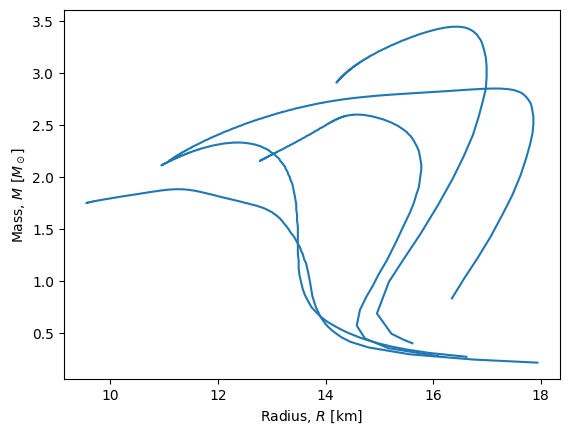

In [15]:
fig, ax = plt.subplots()

for eos in collated_eos.eos[:5]:

    eos = int(eos)

    df = pd.read_csv(f'{target_dir}/macro-draw-{eos:06}.csv')

    mass = df.M
    radius = df.R

    print(np.max(mass))

    ax.plot(
        radius, 
        mass, 
        alpha=1, 
        c='C0'
        )

# ax.set_xlim(6, 18)
# ax.set_ylim(0.8, 2.2)

ax.set_xlabel('Radius, $R$ [km]')
_ = ax.set_ylabel('Mass, $M$ [$M_\odot$]')

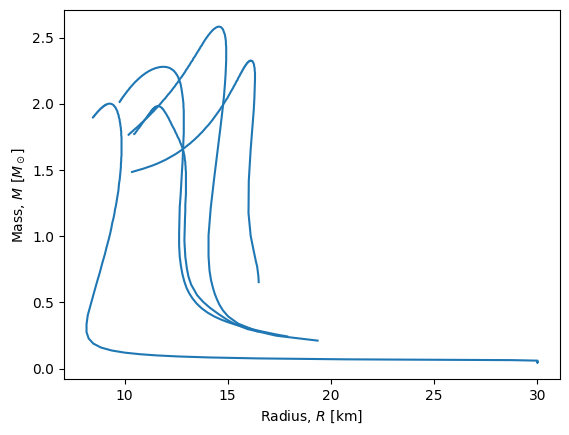

In [16]:
fig, ax = plt.subplots()

max_mass_list = []

for eos in collated_eos.eos[100:105]:

    eos = int(eos)

    df = pd.read_csv(f'{target_dir}/macro-draw-{eos:06}.csv')

    mass = df.M
    radius = df.R

    turning_index = np.argmax(mass)
    # mass = mass[:turning_index]
    # radius = radius[:turning_index]

    max_mass_list.append(np.max(mass))

    ax.plot(
        radius, 
        mass, 
        alpha=1, 
        c='C0'
        )

# ax.set_xlim(6, 18)
# ax.set_ylim(0.8, 2.2)

ax.set_xlabel('Radius, $R$ [km]')
_ = ax.set_ylabel('Mass, $M$ [$M_\odot$]')

In [17]:
min(max_mass_list)

1.9829568910300956

In [18]:
# Load the full EoS data from the GP draws, and interpolate onto a consistent
# mass grid

mass_grid = np.linspace(0.8, 1.8, 1000)
radius_interp = []

for eos in collated_eos.eos[:2000]:

    eos = int(eos)

    df = pd.read_csv(f'{target_dir}/macro-draw-{eos:06}.csv')

    radius = df.R.values
    mass = df.M.values

    turning_index = np.argmax(mass)
    mass = mass[:turning_index]
    radius = radius[:turning_index]

    try:
        radius_interp.append(interp1d(mass, radius)(mass_grid))
    except:
        pass

radius_interp = np.array(radius_interp)

# Compute the weighted quantiles of the radius at each mass, using the 
# pre-computed weights
weighted_quantiles = []

for i in range(len(mass_grid)):
    weighted_quantiles.append(weighted_quantile(radius_interp[:,i], [0.05, 0.5, 0.95], weights=astro_weights[:2000]))

weighted_quantiles = np.array(weighted_quantiles).T

In [19]:
len(radius_interp)

1954

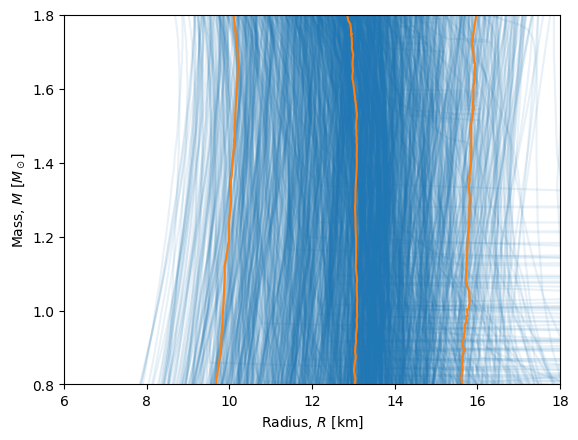

In [20]:
fig, ax = plt.subplots()

for r in radius_interp:

    ax.plot(
        r, 
        mass_grid, 
        alpha=0.1, 
        c='C0'
        )
    
ax.plot(weighted_quantiles[0], mass_grid, c='C1')
ax.plot(weighted_quantiles[1], mass_grid, c='C1')
ax.plot(weighted_quantiles[2], mass_grid, c='C1')

ax.set_xlim(6, 18)
ax.set_ylim(0.8, 1.8)

ax.set_xlabel('Radius, $R$ [km]')
_ = ax.set_ylabel('Mass, $M$ [$M_\odot$]')